In [143]:
import pandas as pd
import networkx as nx
import statistics as st
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import random

# Data Preprocessing

The main focus of the following preprocessing steps is to remove the discrepancies between the names among the three datasets. Analising the data it can be seen that the last character of almost every row in the $heronetwork$ dataset should be removed (with 2 exeptions), also the name of $spiderman$ needed to be standardized for all three datasets.  
Other actions were performed to add some columns to the $heronetwork$, such as the weights and a label, in preparation for the next part.  
The weight of an edge/collaboration will be the inverse of the number of that collaborations, including the mirrored rows.

In [14]:
edges = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")
network = pd.read_csv("hero-network.csv")
nodes.loc[nodes["node"]=="SPIDER-MAN/PETER PARKERKER", "node"] = "SPIDER-MAN/PETER PA"
edges.loc[edges["hero"]=="SPIDER-MAN/PETER PARKER", "hero"] = "SPIDER-MAN/PETER PA"
def lastcharem(x):
    if x == "SABRE": return x
    if x == "BLADE": return x
    else:
        y = list(x)
        del y[-1]
        return "".join(y)

In [15]:
herolist_nodes = nodes["node"].loc[nodes["type"]=="hero"].tolist()
nethero1list = network.hero1.tolist()
hero1discrepancy = (list(set(nethero1list) - set(herolist_nodes)))
nethero2list = network.hero2.tolist()
hero2discrepancy = (list(set(nethero2list) - set(herolist_nodes)))

In [16]:
network.loc[network.hero1.isin(hero1discrepancy), "hero1"] = network.loc[network.hero1.isin(hero1discrepancy), "hero1"].apply(lambda row: lastcharem(row))
network.loc[network.hero2.isin(hero1discrepancy), "hero2"] = network.loc[network.hero2.isin(hero2discrepancy), "hero2"].apply(lambda row: lastcharem(row))
network.drop(network[network.hero1==network.hero2].index, inplace=True)

In [17]:
network["idx"] = 1
dictionary1 = network.groupby(["hero1","hero2"]).count().to_dict(orient="dict")

def weight(x, y, d1):
    output = []
    if (x,y) in d1["idx"]: output.append(d1["idx"][(x,y)])
    if (y,x) in d1["idx"]: output.append(d1["idx"][(y,x)])
        
    return 1/(sum(output))


In [18]:
# final weights
network["weight"] = network.apply(lambda row: weight(row["hero1"], row["hero2"], dictionary1), axis=1)
# extra label
network["label"] = network.apply(lambda row: row.hero1+" | "+row.hero2, axis=1)

In [19]:
network.to_pickle("network")
nodes.to_pickle("nodes")
edges.to_pickle("edges")

# Backend

### Graphs Creation
The purpose of this section is to create the two graphs from the processed data, as well as the subgraphs of interest.  
The subgraphs are built by taking the top N heroes with the highest number of appearences in comics.
Regarding the subgraph of the second graph we opted to build it taking, alongside the top heroes, $N/3$ of the comics in which they appear, in order to create a graph that is not entirely disconnected, while keeping it of a manageable size.

In [20]:
# Graphs initialization:
network = pd.read_pickle("network")
nodes = pd.read_pickle("nodes")
edges = pd.read_pickle("edges")

# First graph
G = nx.MultiGraph()
network.apply(lambda row: G.add_edge(row["hero1"], row["hero2"], weight=row["weight"], label=row["label"] ), axis=1) 
G_1 = nx.Graph(G)

# Second graph
G_2 = nx.Graph()
nodes.apply(lambda row: G_2.add_node(row["node"], kind = row["type"]), axis=1)
edges.apply(lambda row: G_2.add_edge(row["hero"], row["comic"]), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
96099    None
96100    None
96101    None
96102    None
96103    None
Length: 96104, dtype: object

In [21]:
# generation of the subgraphs
def sub_g1(G_1,N):
    topheroes = edges.groupby("hero",as_index=False).count().sort_values(by="comic",ascending=False).head(N).hero.tolist()    
    G = G_1.subgraph(topheroes)
    return G

def sub_g2(G_2,N):
    topheroes = edges.groupby("hero",as_index=False).count().sort_values(by="comic",ascending=False).head(N).hero.tolist()
    topcomics = edges.loc[(edges.hero.isin(topheroes))].groupby("hero", as_index=False).head(N//3).comic.tolist()
    G = G_2.subgraph(topheroes+topcomics)
    return G

### Functionality 1
This function extracts the features of the selected graph.  
Its structure is split in two, only one of the two part will be executed depending on the graph type. For the second graph some features were split for the two types of nodes.

In [114]:
def Functionality_1(G, graphtype):
    
    if graphtype == 1:
        
        # Number of nodes
        number_nodes = len(G.nodes())   
        #The number of collaborations of each superhero with the others (only if type 1)
        co_list = {}
        for i in G.nodes():
            co_list[i] = G.degree[i]       
        # density
        d = nx.density(G)
        # degree distribution
        deg_distro = []
        for i in G.nodes():
            deg_distro.append(G.degree[i])
        deg_distro_2 = []
        # mean degree
        mean_deg = sum(deg_distro)/len(deg_distro)
        mean_deg_2 = []
        # hubs
        hubvalue = np.percentile(deg_distro, 95)
        hubs = [k for k in G.nodes if G.degree[k] > hubvalue]
        # sparsity
        if nx.density(G) >= 0.2:
            sparsity = "Dense"
        else: sparsity = "Sparse"

    if graphtype == 2:
        
        # Number of nodes    
        comicsublist = [k for k,v in G.nodes(data=True) if v["kind"] == "comic"]
        herosublist = [k for k,v in G.nodes(data=True) if v["kind"] == "hero"]
        number_comicnode = len(comicsublist)
        number_heronode = len(herosublist)
        number_nodes = [number_comicnode, number_heronode]
        #The number of heroes that have appeared in each comic (only if type 2)
        co_list = {}
        for i in comicsublist:
            co_list[i] = G.degree[i]
        # density
        d = nx.density(G)
        # degree distribution for comics
        deg_distro = []
        for i in comicsublist:
            deg_distro.append(G.degree[i])
        # degree distribution for heroes
        deg_distro_2 = []
        for i in herosublist:
            deg_distro_2.append(G.degree[i])
        # mean degree for comics
        mean_deg = sum(deg_distro)/len(deg_distro)
        # mean degree for heroes
        mean_deg_2 = sum(deg_distro_2)/len(deg_distro_2)
        # hubs
        hubvalue = np.percentile(deg_distro, 95)
        hubs = [k for k,v in G.nodes(data=True) if G.degree[k]>hubvalue if v["kind"] == "comic"]
        # sparsity
        if nx.density(G) >= 0.2:
            sparsity = "Dense"
        else: sparsity = "Sparse"   

    return (number_nodes, co_list, d, deg_distro, deg_distro_2, mean_deg, mean_deg_2, hubs, sparsity)



### Functionality 2
This function computes the selected metric of the node of interest and the mean of whole graph, the metrics that can be used are: Betweeness centrality, PageRank, Closeness centrality and Degree centrality.  
Being only one of the graphs weighted, the computation of the metrics is split depending on the selected type of graph.

In [50]:
def Functionality_2(G, graphtype, node, metric):

    if graphtype == 1:

        if metric == 1:
            betweenness = nx.betweenness_centrality(G, weight = "weight")
            output = betweenness[node]
            out_mean = st.mean(betweenness.values())
        if metric == 2: 
            pagerank = nx.pagerank(G, weight = "weight")
            output = pagerank[node]
            out_mean = st.mean(pagerank.values())
        if metric == 3: 
            closeness = nx.closeness_centrality(G, distance = "weight")
            output = closeness[node]
            out_mean = st.mean(closeness.values())
        if metric == 4: 
            degree = nx.degree_centrality(G)
            output = degree[node]
            out_mean = st.mean(degree.values())

    if graphtype == 2:

        if metric == 1:
            betweenness = nx.betweenness_centrality(G)
            output = betweenness[node]
            out_mean = st.mean(betweenness.values())
        if metric == 2: 
            pagerank = nx.pagerank(G)
            output = pagerank[node]
            out_mean = st.mean(pagerank.values())
        if metric == 3: 
            closeness = nx.closeness_centrality(G)
            output = closeness[node]
            out_mean = st.mean(closeness.values())
        if metric == 4: 
            degree = nx.degree_centrality(G)
            output = degree[node]
            out_mean = st.mean(degree.values())

    return (output, out_mean)



### Functionality 3
This functionality computes the shortest walk between a series of nodes in order, it achieves this by computing the shortest path between each node of the series and then storing consecutively the output, at the end the "hero" nodes were dropped from the list to leave only the comics.

In [10]:
def Functionality_3(G_2, h, h_1, h_n):
    
    h_all = h_1 + h + h_n    
    walk = []
    for i in range(1,len(h_all)):
        if nx.has_path(G_2, h_all[i-1], h_all[i]):
            walk += (nx.shortest_path(G_2, source=h_all[i-1], target=h_all[i]))
            walk.pop()        
        else:
            walk = str("There is no such path")
            break
    comic_walk = []
    for i in walk:
        if G_2.nodes(data=True)[i] == {"kind": "comic"}: comic_walk.append(i)

    return comic_walk



### Functionality 4
This function computes the minimum cut to separate 2 nodes in distinct subgraphs. The algorithm used is based on Karger's algorithm, being a random algorithm the exact result is not guaranteed, the probability for the output to be the exact solution raises as the number of iterations increases.  
The main idea behind Karger's algorithm is to contract pair of adjacent nodes until only the two nodes of interest remain, the resulting edges will be the ones left to cut in order to separate them.

In [109]:
def Functionality_4(G, graphtype, node1, node2, iterations):

    G_red = nx.MultiGraph(G.copy())
    minimum = nx.MultiGraph()
    
    for i in range(iterations):            # iterative cycle to find the minimum
        G_copy = nx.MultiGraph(G.copy())
        while len(G_copy.nodes()) > 2:               # cycle of each cut attempt
            minimum = G_copy.copy()
            nodelist = []
            for node in G_copy.nodes():
                nodelist.append(node)
            node_a = random.choice(nodelist)         # random choiche of adjacent nodes
            near_a = list(G_copy.neighbors(node_a))
            if len(near_a) == 0: continue
            node_b = random.choice(near_a)
            if (node_a==node1) & (node_b==node2):    # making sure the nodes of interest wont
                continue                             # be contracted or disappear in a contraction
            elif (node_a==node2) & (node_b==node1):
                continue              
            elif node_a == node1:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)
            elif node_a == node2:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)
            elif node_b == node1:
                nx.contracted_nodes(G_copy, node_b, node_a, self_loops = False, copy = False)
            elif node_b == node2:
                nx.contracted_nodes(G_copy, node_b, node_a, self_loops = False, copy = False)
            else:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)          
        minimum = G_copy.copy()
                       # sizing the cut depending on the weights (if graph 1) and keeping the minimum
        if graphtype == 1:
            if minimum.size(weight="weight") <= G_red.size(weight="weight"):
                G_red = minimum.copy()
            output = G_red.size(weight="weight")
        if graphtype == 2:
            if minimum.size(weight=None) <= G_red.size(weight=None):
                G_red = minimum.copy()
            output = G_red.size(weight=None)
        
    return G_red



### Functionality 5
We Implement the 5th functionality using the Girvan-Newman algorithm. The communities in a graph are discovered by iteratively removing the edges of the graph, based on the edge betweenness centrality value.
The edge with the highest edge betweenness is removed first. 

In [28]:
#This function return the edge wich has to be removed beacuese has the highest score
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

  # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

According to the Girvan-Newman algorithm, after computing the EBC scores, the edges with the highest scores will be taken off till the point the graph splits into two.

In [31]:
#This function call edge_to_remove till the graph splits into two
def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)
    edg_count = 0

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)
        edg_count += 1

    return sg , edg_count

In [87]:
#This function return the number of links which split the graph, the node sets belonging to two communities 
#and a boolean variable that is True if hero_1 and hero_2 are in the same community
def Functionality_5(G, N, hero_1, hero_2):
    #create the sub graph of N nodes
    G1_sub= sub_g1(G,N)
    same_com=False
    
    # find communities in the graph
    c , e_count = girvan_newman(G1_sub.copy())

    # find the nodes forming the communities
    node_groups = []

    for i in c:
        node_groups.append(list(i))
    for i in range(len(node_groups)):
        if hero_1 in node_groups[i] and hero_2 in node_groups[i]:
            same_com == True
            break
    
    return e_count, node_groups, same_com

### Visualization 5 - Visualize the communities

Print the number of links that should be removed to have the communities

In [121]:
num_link,nodes_g,components= Functionality_5(G1_sub, 20, 'SUB-MARINER/NAMOR MA', 'MR. FANTASTIC/REED R')

In [122]:
num_link

19

A table depicting the communities and the heroes that belong to each community

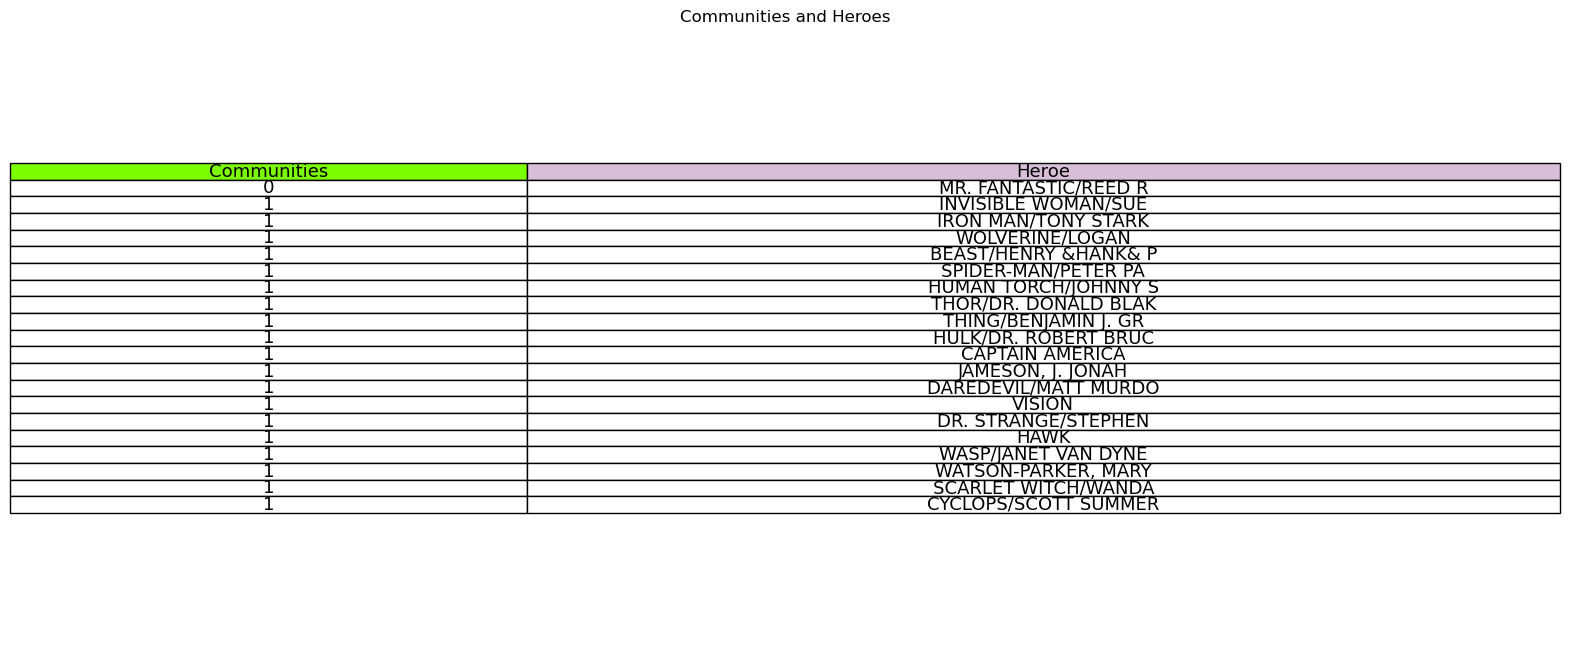

In [123]:
data=[]
for i in range(len(nodes_g)):
    for el in nodes_g[i]:
        data.append([i,el])
    
plt.rcParams["figure.figsize"] = (18,8)
table = plt.table(cellText=data, colWidths=[1/3,2/3], colLabels=['Communities', 'Heroe'], loc='center', 
                  cellLoc='center', colColours=['lawngreen', 'thistle'])
table.auto_set_font_size(False)
table.set_fontsize(13)

plt.title('Communities and Heroes')
plt.axis('off')
plt.show()

Plot the original graph

In [ ]:
plt.figure(3, figsize=(20, 15)) 
nx.draw(g2_sub2, pos, node_color = color, with_labels = True, node_size = 1500 )
nx.draw_networkx_edge_labels(g2_sub2, pos, edge_labels = edge_l, font_size = 13, font_color = "red")

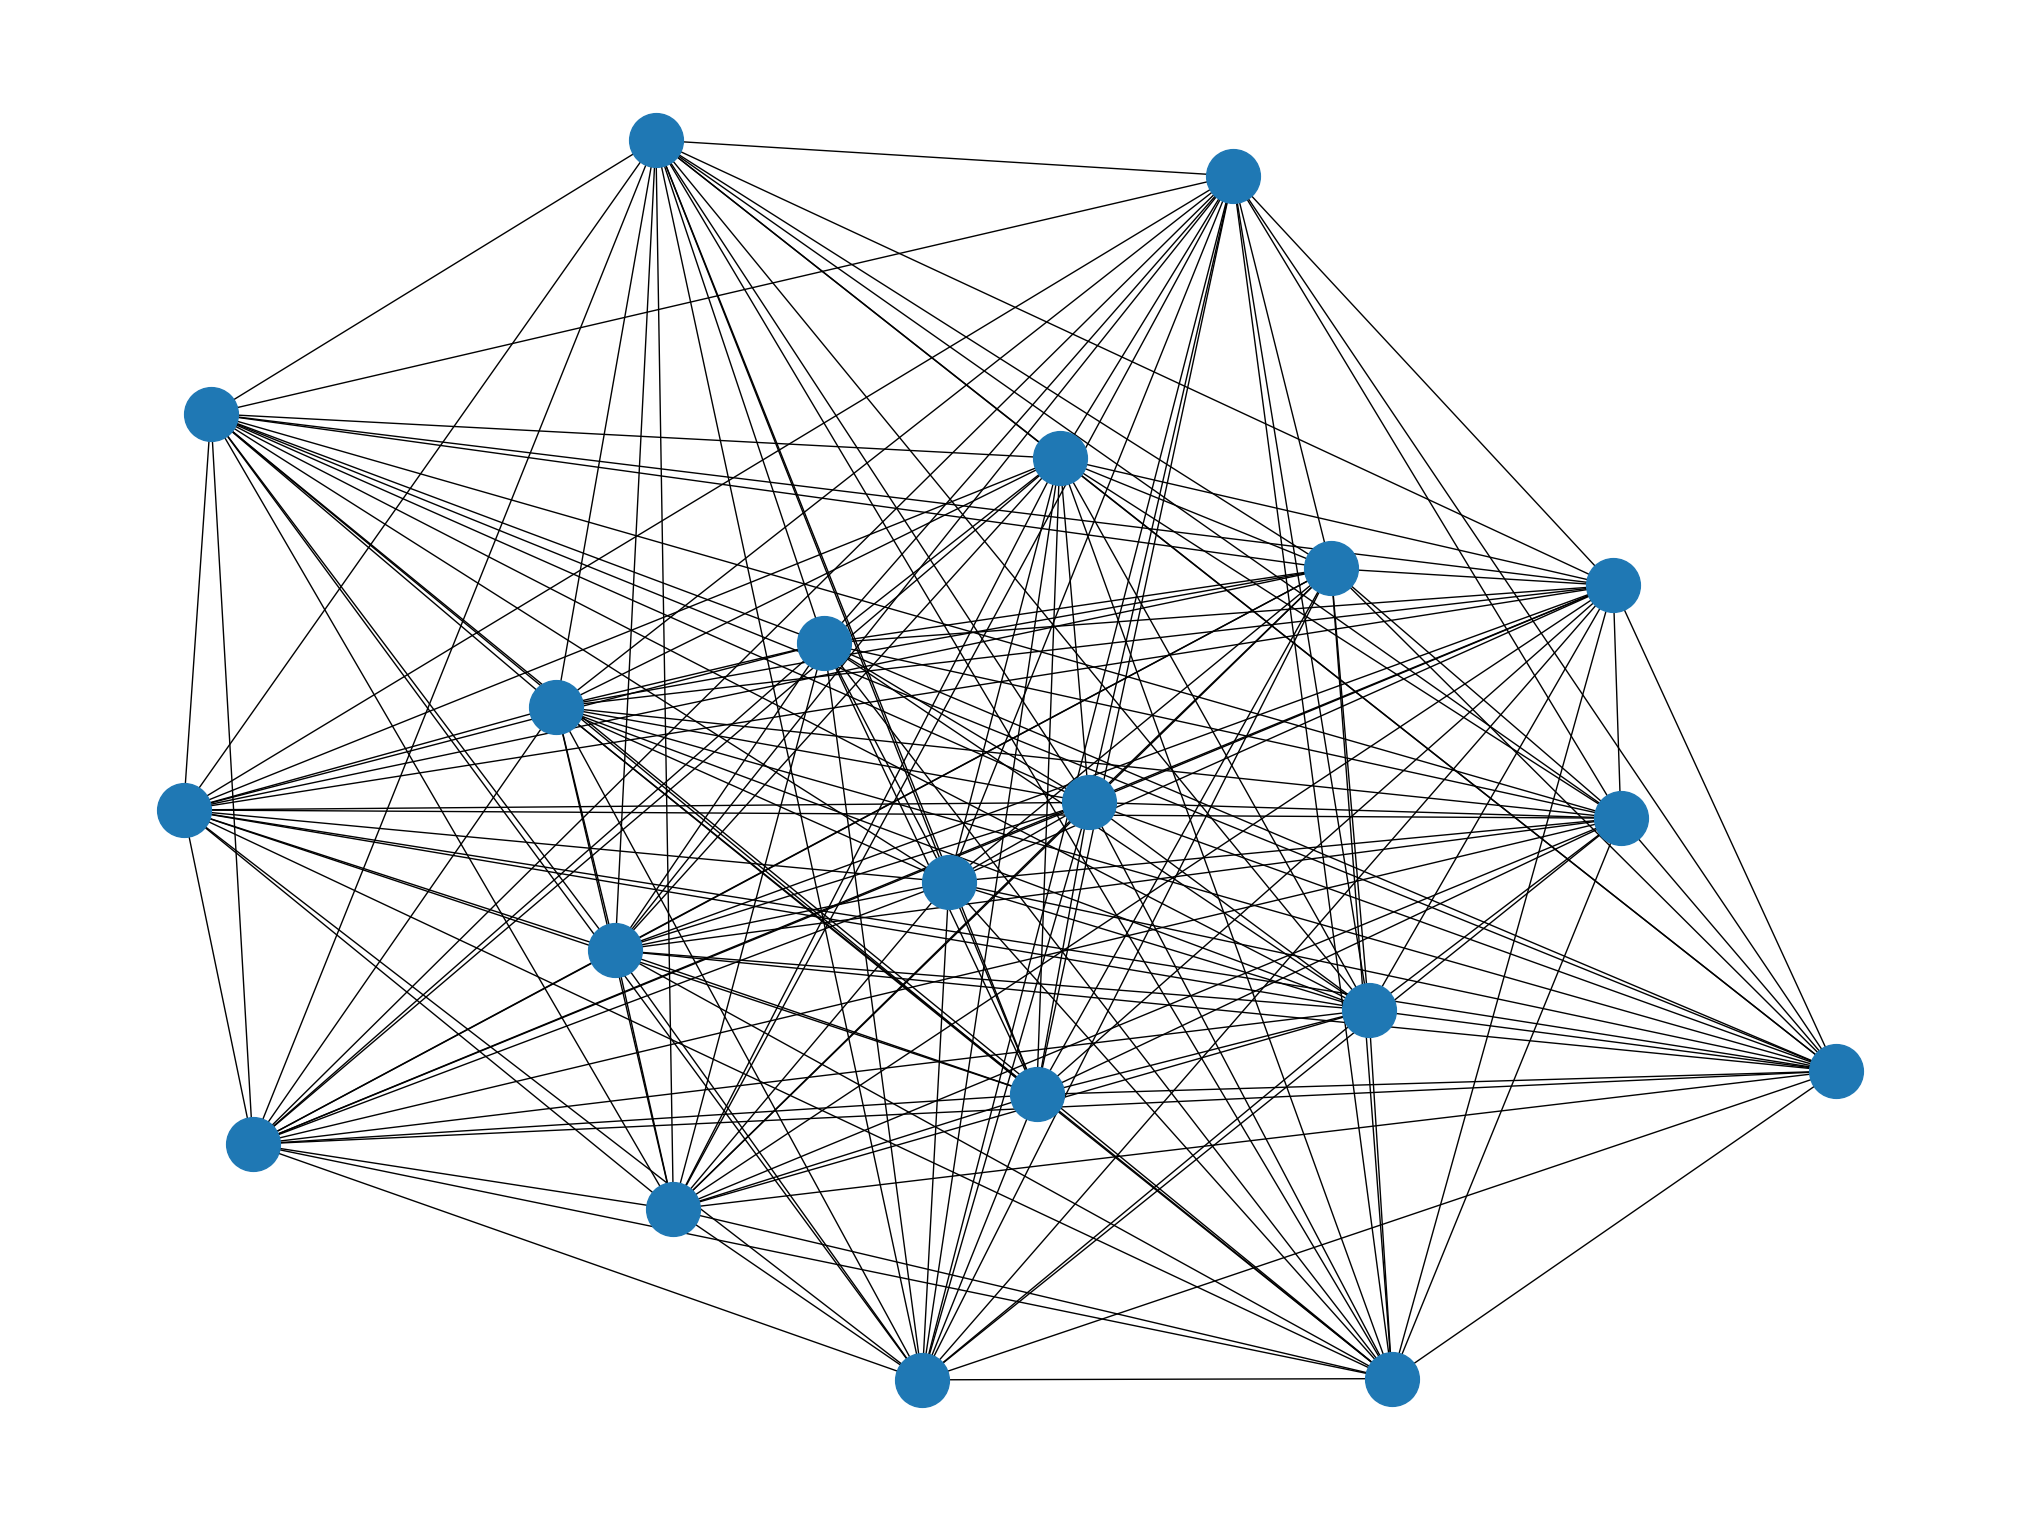

In [130]:
G1_sub= sub_g1(G_1,20)
plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub,node_size = 1500)


Plot the graph showing the communities in the network

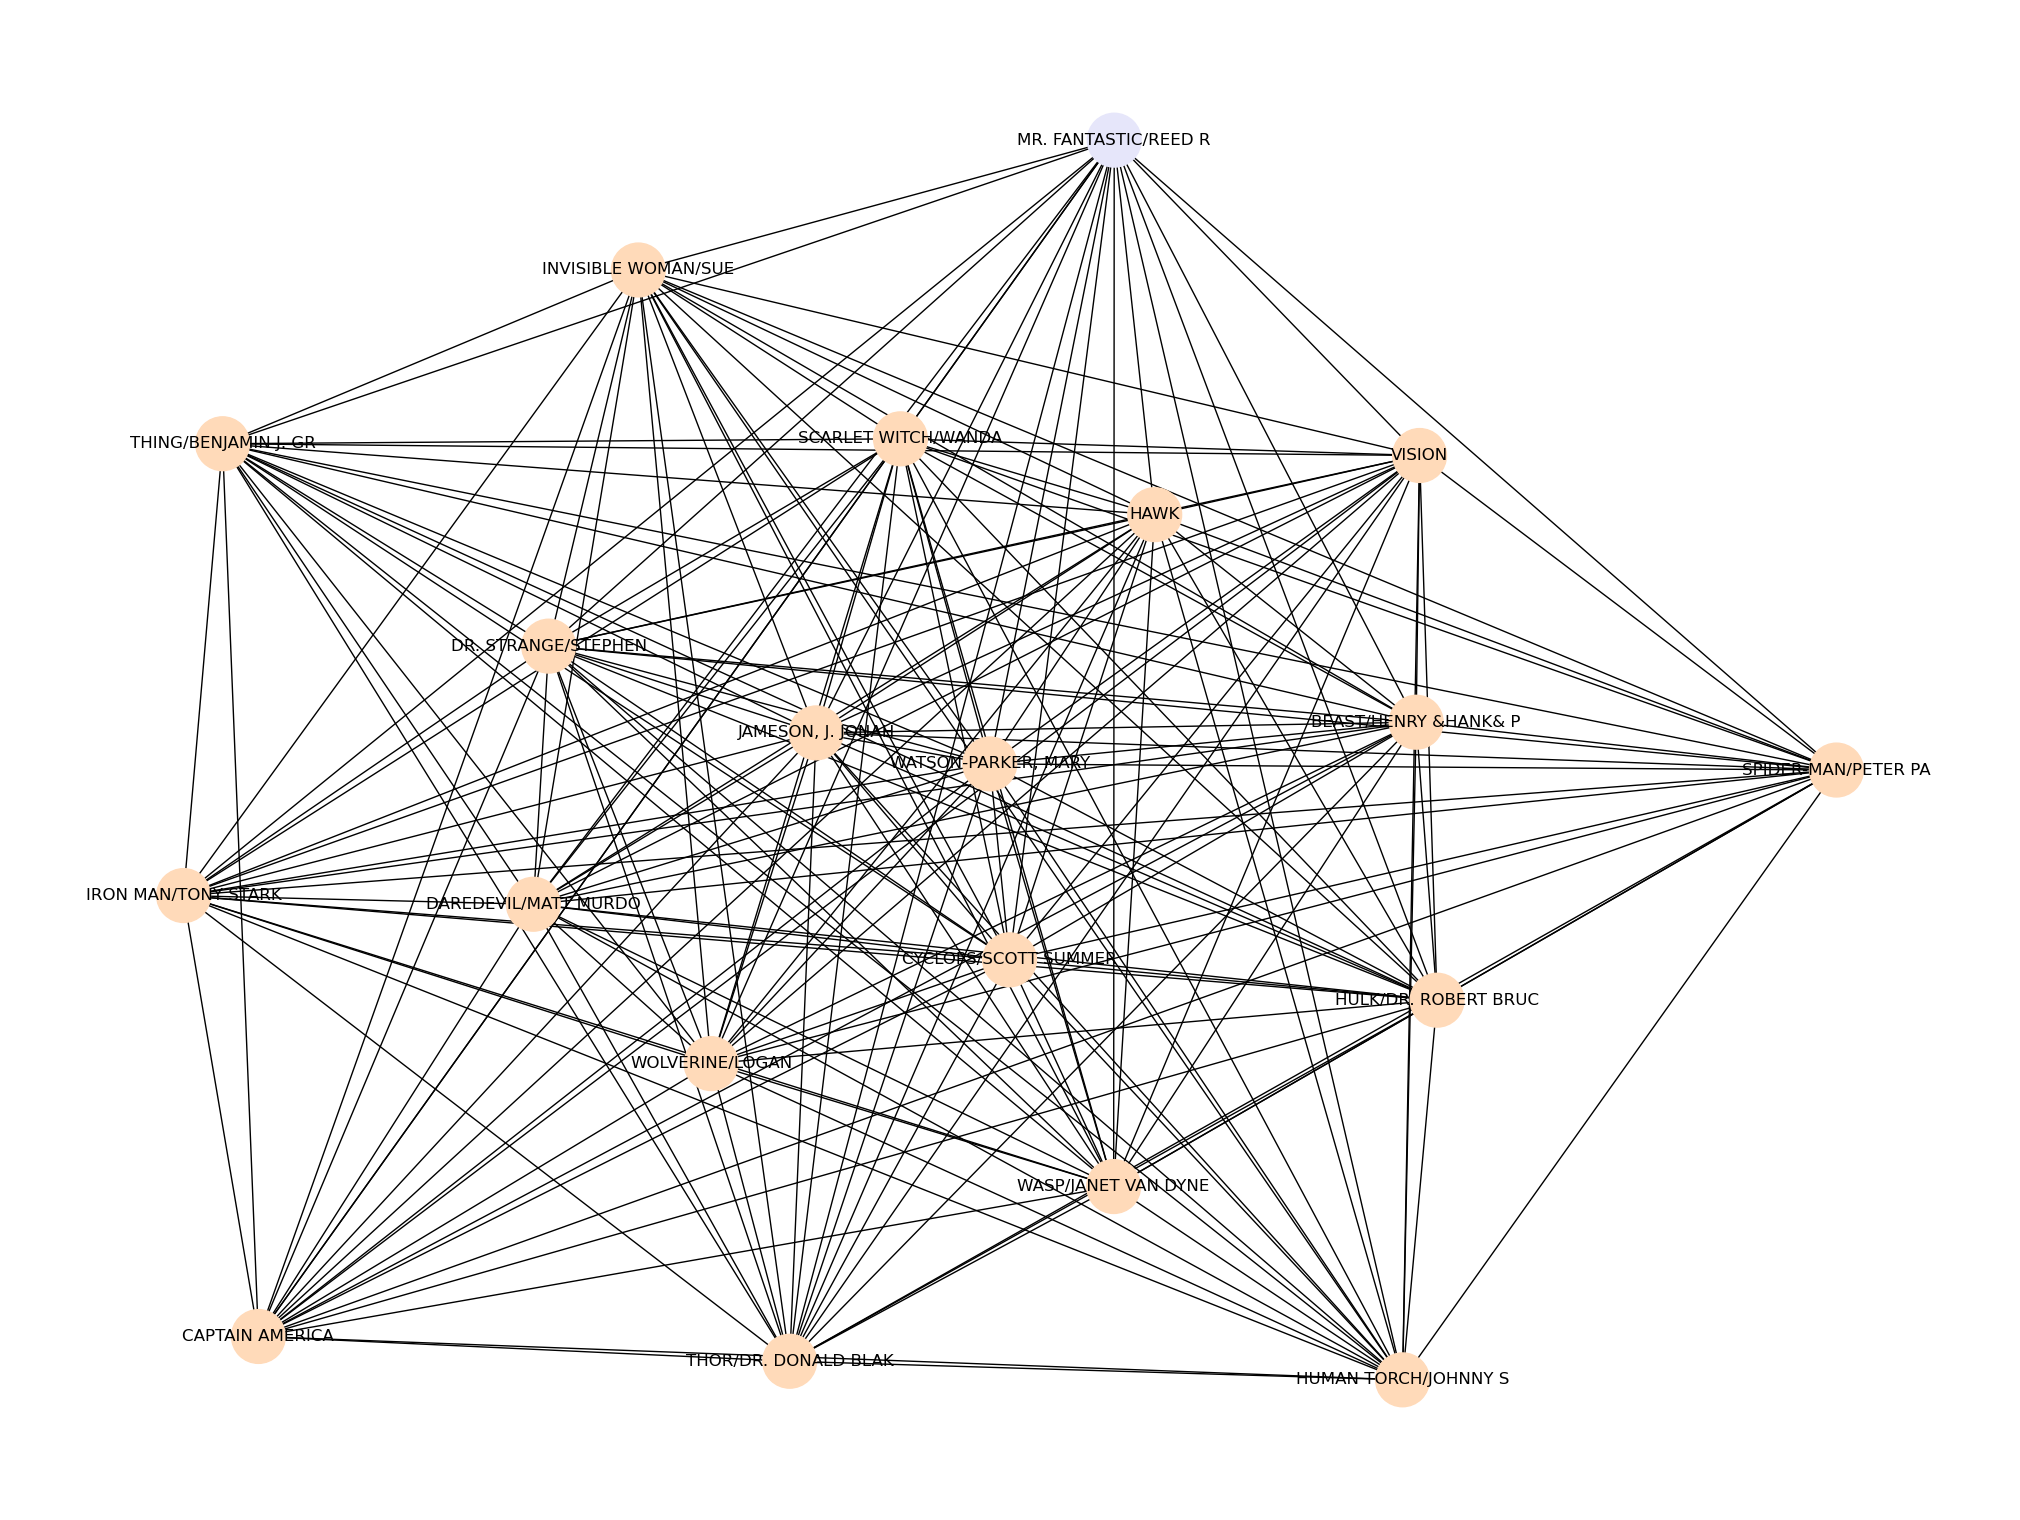

In [134]:
# plot the communities
color_map = []
for node in G1_sub:
    if node in nodes_g[0]:
        color_map.append('lavender')
    else: 
        color_map.append('peachpuff')  

plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub, node_color=color_map, with_labels=True,node_size = 1500)
plt.show()

Plot the final graph and identify the community/communities of Hero_1 and Hero_2

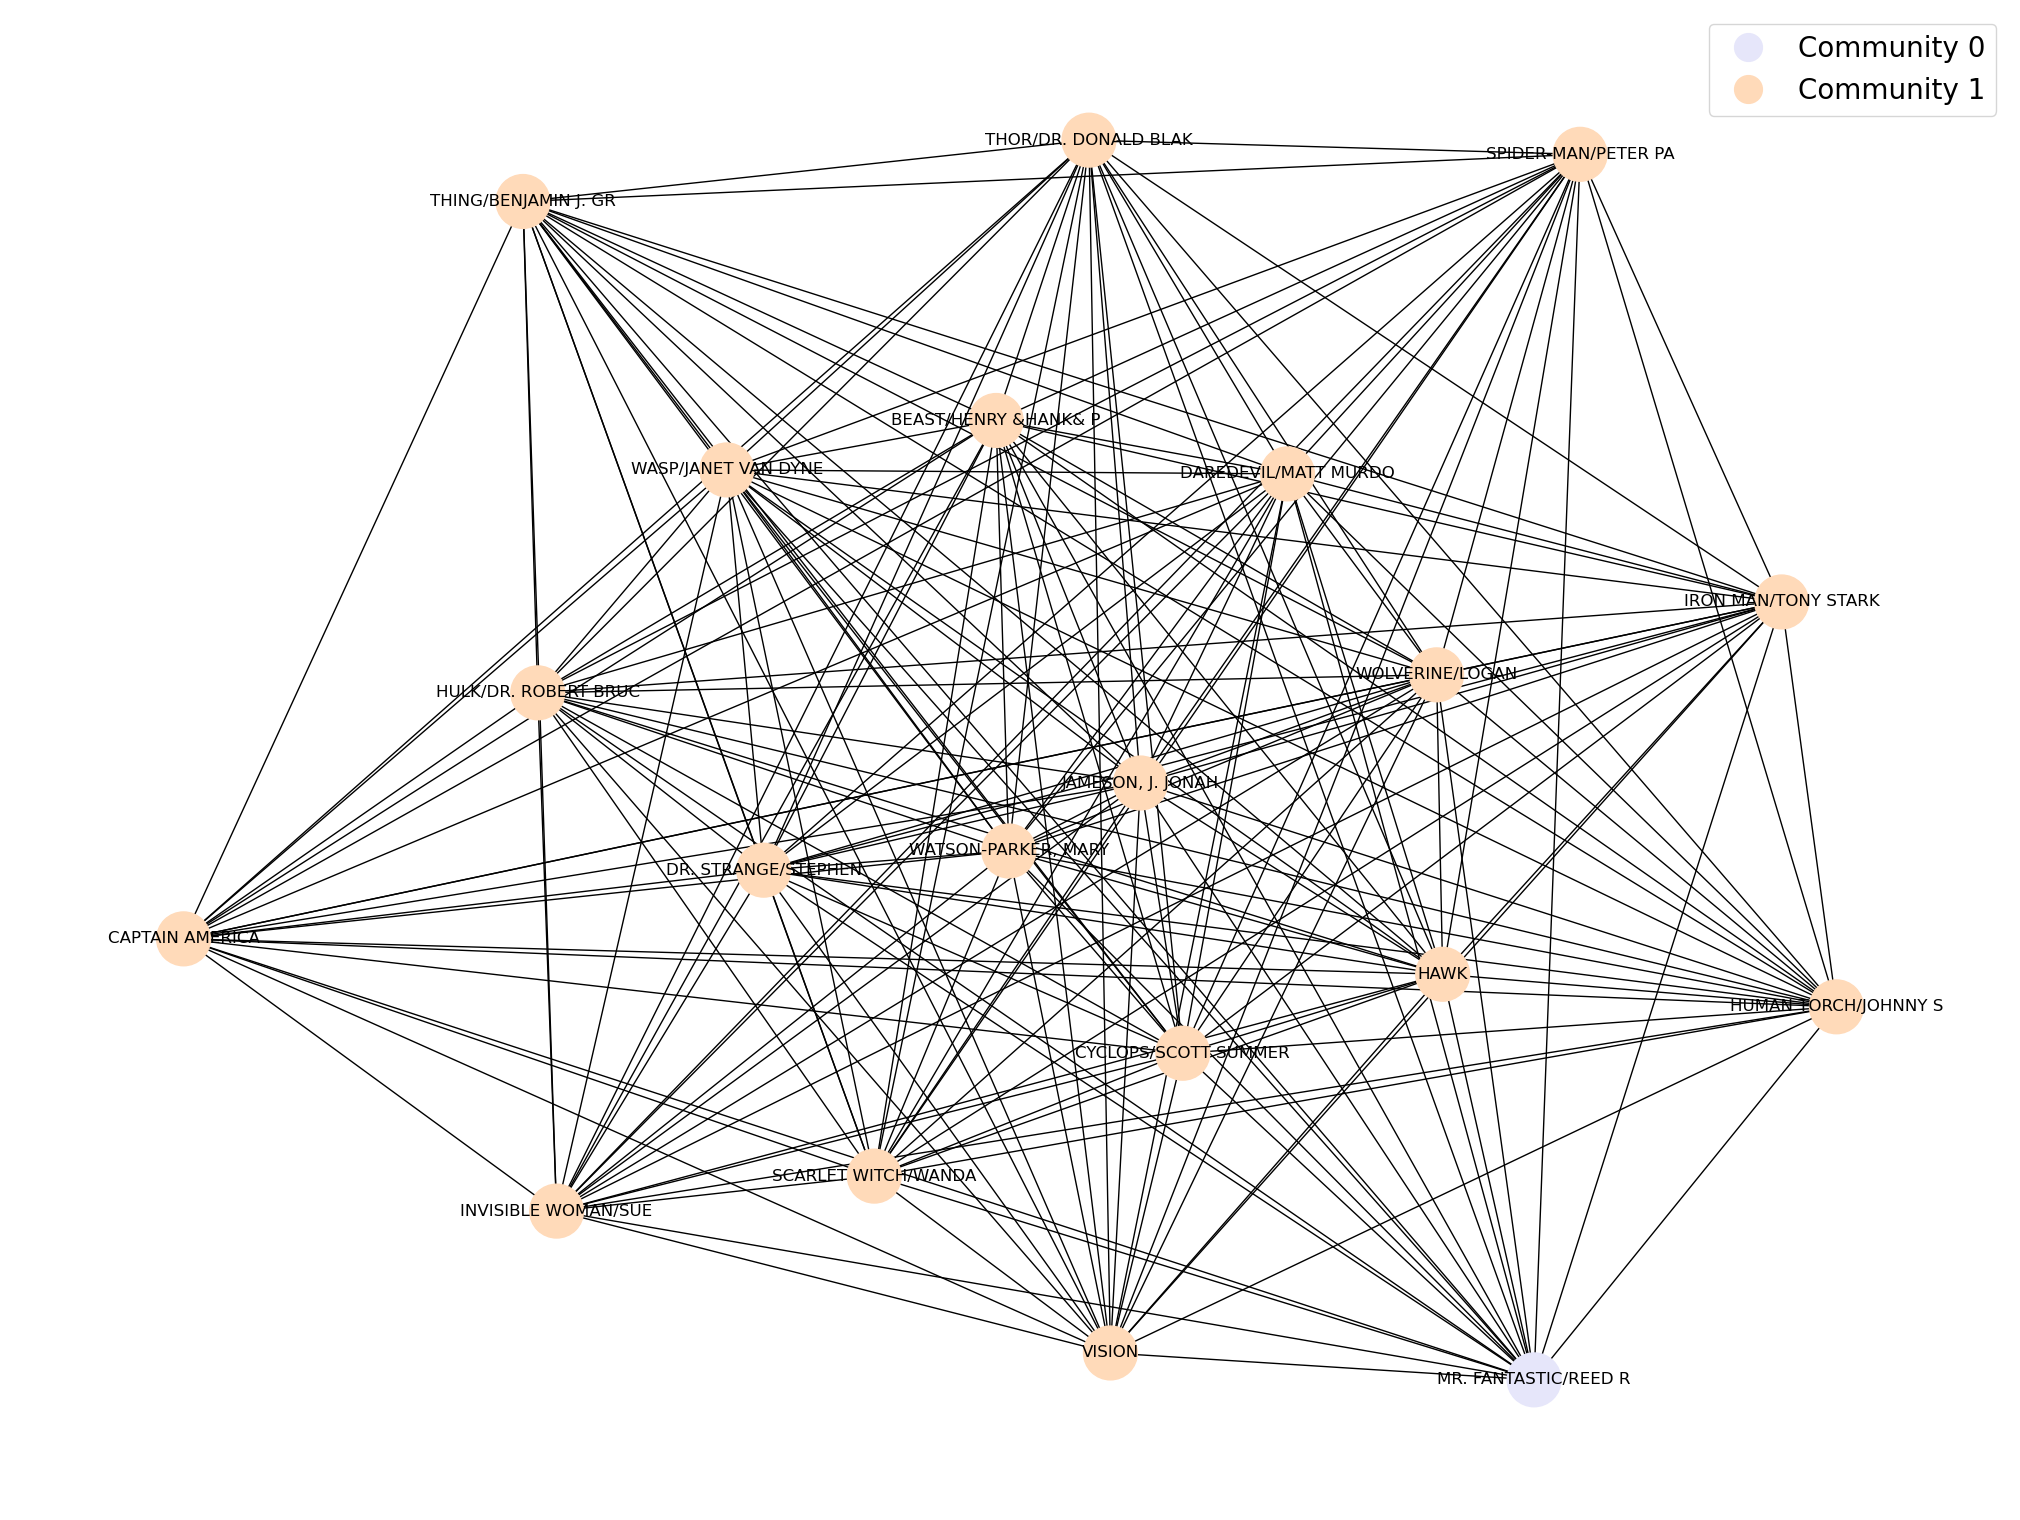

In [148]:
plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub, node_color=color_map, with_labels=True,node_size = 1500)

Community_0 = mlines.Line2D([], [], color='lavender', marker='o', linestyle='None',
                          markersize=20, label='Community 0')
Community_1 = mlines.Line2D([], [], color='peachpuff', marker='o', linestyle='None',
                          markersize=20, label='Community 1')

plt.legend(handles=[Community_0,Community_1],fontsize=20)
plt.show()